In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from win10toast import ToastNotifier
import ssl
from bs4 import BeautifulSoup 
from datetime import datetime
from datetime import date, timedelta
import requests


Write Up: In this project, I collected 10 of the top 25 traded etf stocks (according to YAHOO Finace). To keep the data up to date, I implementated an automatic web scraper that can be applied to any etf (All data is from stockanalysis.com). In addition to the web scraper, I implemented an automatic notifier to send out a windows notification if a etf is at the lowest or highest price in the past month. Once the data is updated, every etf's current open price is ran through the notifier to analyze the price. Lastly, this project looks at the the change of these etf's over the past year, trying to identify any particular trend of why these etf's are permoning as is. 

Author: Eddie Knutson
Last Updated: 12/30/2024

In [2]:
AGG = pd.read_csv('AGG.csv', encoding='latin1')
IVV = pd.read_csv('IVV.csv', encoding='latin1')
QQQ = pd.read_csv('QQQ.csv', encoding='latin1')
RSP = pd.read_csv('RSP.csv', encoding='latin1')
SCHD = pd.read_csv('SCHD.csv', encoding='latin1')
SPY = pd.read_csv('SPY.csv', encoding='latin1')
VO = pd.read_csv('VO.csv', encoding='latin1')
VOO = pd.read_csv('VOO.csv', encoding='latin1')
VTI = pd.read_csv('VTI.csv', encoding='latin1')
XLK = pd.read_csv('XLK.csv', encoding='latin1')


In [3]:
symbols = [ IVV, QQQ, RSP, SPY, VO, VOO, VTI, XLK]
symbol = [ 'IVV', 'QQQ', 'RSP', 'SPY', 'VO', 'VOO', 'VTI', 'XLK']

SPY.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj. Close', 'Change',
       'Volume'],
      dtype='object')

Cleaning Process: Drop all null rows.

In [4]:
for x in range(len(symbols)):
    symbols[x].dropna(inplace=True)



In [5]:

#data = { 
  #  'Date': ['Dec 19, 2024'],
  #  'Open': ['543.69'],
   # 'High': ['545.10'],
   # 'Low': ['538.65'],
   # 'Close': ['538.9'],
   # 'Adj. Close': ['538.94'],
   # 'Change': ['-0.04%'],
  #  'Volume': ['16,792,125']}
#df = pd.DataFrame(data)
global symbols
def deleteCharacter(text, days):
    x = 42
    y = 99
    z = 99 - 42
    #add 
    short_date = 6
    negative = 43
    dd_vol = 50
    y = y + days*z
    x = x + days*z
    add = '0.00%'
    if text[x:y][1] not in ['J', 'F', 'M', 'A', 'S', 'O', 'N', 'D'] :
        while text[x + 1] not in ['J', 'F', 'M', 'A', 'S', 'O', 'N', 'D']:
            x = x + 1
            y = y + 1
    if text[x:y][short_date] == ',':
        y = y + 1
        dd_vol = dd_vol + 1
        negative = negative + 1
    if text[x:y][negative] == '-':
        #if 
        if text[x:y][negative + 2] != '.':
            dd_vol = dd_vol - 4
            y = y - 4
            
        else:
            y = y + 1
            dd_vol = dd_vol + 1
    if text[x:y][dd_vol] == ',':
        y = y + 1
    
    #selects appropriate amount of characters

    text = text[x:y]
    if len(text) == 53:
        first = text[0:negative]
        last = text[negative+1:53]
        text = first + add + last
    return text

def updateData(symbol):
    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36'}
    url = f'https://stockanalysis.com/etf/{symbol}/history/'
    
    r = requests.get(url)

    soup = BeautifulSoup(r.text, 'html.parser')
    
    price = soup.find('table', {'class': 'svelte-2d4szo'}).text
    change = soup.find('span', {'class': 'rg'}).text
    return price
        
def isWeekday(date):
    #helper function, returns true if weekday, returns false if weekend
    formated = date.strftime('%b %d, %Y')
    date_object = datetime.strptime(formated, '%b %d, %Y')
    day_week = date_object.strftime("%A")
    if (day_week == 'Sunday') or (day_week == 'Saturday'):
        return False
    else:
        return True

def updateDataSet(symbol, starting_date, etf):
    #declare global variable to access
    today = datetime.now().date()
    days = (today - starting_date).days 
    print(symbol)
    while starting_date <= today:
        if (isWeekday(starting_date)):
            uncleanedData = updateData(symbol)
            select = deleteCharacter(uncleanedData, days)
            short_date = 6
            negative = 43
            dd_vol = 50
            x1 = 0
            x2 = 13
            x3 = 19
            x4 = 25
            x5 = 31
            x6 = 37
            x7 = 43
            x8 = 48
            x9 = 57
            if select[short_date] == ',':
                dd_vol = dd_vol + 1
                negative = negative + 1
                x2 = x2 + 1
                x3 = x3 + 1
                x4 = x4 + 1
                x5 = x5 + 1
                x6 = x6 + 1
                x7 = x7 + 1
            if select[negative] == '-':
                dd_vol = dd_vol + 1
                x8 = x8 + 1
                x9 = x9 + 1
            if select[dd_vol] == ',':
                x9 = x9 + 1
            #df.loc[-1] = [select[0:12], select[12:18], select[18:24], select[24:30], select[30:36], select[36:42], select[42:47], select[47:56]]
            if select[x1:x2] == today:
                break
            else: 
                new_df = pd.DataFrame({'Date': select[x1:x2], 'Open': select[x2:x3], 'High': select[x3:x4], 'Low': select[x4:x5], 'Close': select[x5:x6],'Adj. Close': select[x6:x7],
                'Change': select[x7:x8], 'Volume': select[x8:x9]}, index = [0])
            
            etf = pd.concat([new_df, VOO[:]]).reset_index(drop = True)
            

        else:
            pass
        days = days -1 
        starting_date = starting_date + timedelta(days=1)
        etf = etf.drop_duplicates()


In [13]:
#calls to update csv files
global symbol
global symbols




x = 0
#while x < len(symbols):
    
Data = updateData(symbol[7])
today = datetime.now().date()
starting_date = symbols[0]['Date'].iloc[0]
starting_date = datetime.strptime(starting_date, '%d-%b-%y').date()


for x in range(len(symbols)):
    updateDataSet(symbol[x], starting_date, symbols[x])


IVV
QQQ
RSP
SPY
VO
VOO
VTI
XLK


In [58]:

for x in range(len(symbols)):
    symbols[x]['Open'] = symbols[x]['Open'].astype(float)
    symbols[x]['Adj. Close'] = symbols[x]['Adj. Close'].astype(float)
    symbols[x]['Change'] = ((symbols[x]['Adj. Close'] - symbols[x]['Open']) / symbols[x]['Open']) * 100

In [8]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
           

In [75]:
def addpercentage(x,y, height):
    for i in range(len(x)):
        plt.text(i, height[i], str(y[i]) + '%', ha = 'center')

In [9]:
global symbols
n = ToastNotifier()
date = ''
date1 = ''
lowest = 1000
highest = 0
x = 0

for y in range(len(symbols)):
    while x < 21:
        x += 1
        if symbols[y]['Open'].iloc[x] < lowest:
            lowest = symbols[y]['Open'].iloc[x]
            date = symbols[y]['Date'].iloc[x]
        if SPY['Open'].iloc[x] > highest:
            highest = symbols[y]['Open'].iloc[x]
            date1 = symbols[y]['Date'].iloc[x]

    if symbols[y]['Open'].iloc[0] == lowest:
        n.show_toast(f"{symbols[y]} Open: ${lowest}", f"Lowest Open in the past 1 month; High: ${highest}", duration = 5)

    if symbols[y]['Open'].iloc[0] == highest:
        n.show_toast(f"{symbols[y]} Open: ${highest}", f"Highest Open in the past 1 month; Low: ${lowest}", duration = 5)


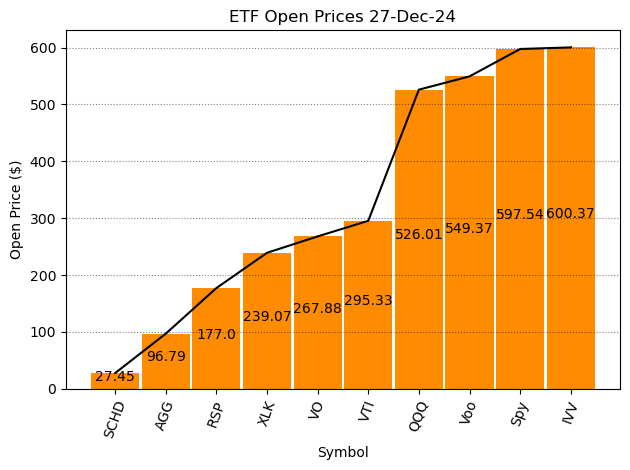

In [ ]:
S1 = float(SPY['Open'].iloc[0])
S2 = float(SCHD['Open'].iloc[0])
A1 = float(AGG['Open'].iloc[0])
I1 = float(IVV['Open'].iloc[0])
R1 = float(RSP['Open'].iloc[0])
V1 = float(VO['Open'].iloc[0])
V2 = float(VOO['Open'].iloc[0])
V3 = float(VTI['Open'].iloc[0])
Q1 = float(QQQ['Open'].iloc[0])
X1 = float(XLK['Open'].iloc[0])

Names = ['SCHD', 'AGG', 'RSP', 'XLK', 'VO','VTI','QQQ', 'Voo','Spy','IVV']

Stocks = [S2, A1, R1, X1, V1, V3, Q1, V2, S1, I1]

plt.bar(Names, Stocks, color = 'darkorange', linestyle ='dashed', width=.95)
addlabels(Names, Stocks)
plt.plot(Names, Stocks, color='black', marker=',', label='Line Data')
plt.xticks(rotation=70)
plt.title(f'ETF Open Prices {SPY['Date'].iloc[0]}')
plt.ylabel('Open Price ($)')
plt.xlabel('Symbols')
plt.grid(axis='y', color = 'black', linestyle=':', alpha=0.5, zorder=0)
plt.tight_layout()
plt.show()

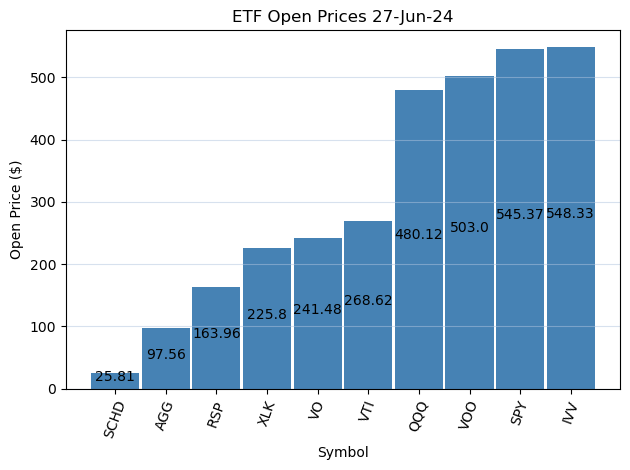

In [ ]:
# Extracting data
S1 = float(SPY['Open'].iloc[127])
S2 = float(SCHD['Open'].iloc[127])
A1 = float(AGG['Open'].iloc[127])
I1 = float(IVV['Open'].iloc[127])
R1 = float(RSP['Open'].iloc[127])
V1 = float(VO['Open'].iloc[127])
V2 = float(VOO['Open'].iloc[127])
V3 = float(VTI['Open'].iloc[127])
Q1 = float(QQQ['Open'].iloc[127])
X1 = float(XLK['Open'].iloc[127])

# Names and Stocks lists
Names = ['SCHD', 'AGG', 'RSP', 'XLK', 'VO', 'VTI', 'QQQ', 'VOO', 'SPY', 'IVV']
Stocks = [S2, A1, R1, X1, V1, V3, Q1, V2, S1, I1]

# Plotting
plt.bar(Names, Stocks, color='steelblue', width = 0.95)
addlabels(Names, Stocks)
plt.grid(axis= 'y', alpha = 0.5, color = 'lightsteelblue')
plt.xticks(rotation=70)
plt.title(f'ETF Open Prices {SPY['Date'].iloc[127]}')
plt.xlabel('Symbols')
plt.ylabel('Open Price ($)')

plt.tight_layout()  # Prevent clipping of labels
plt.show()


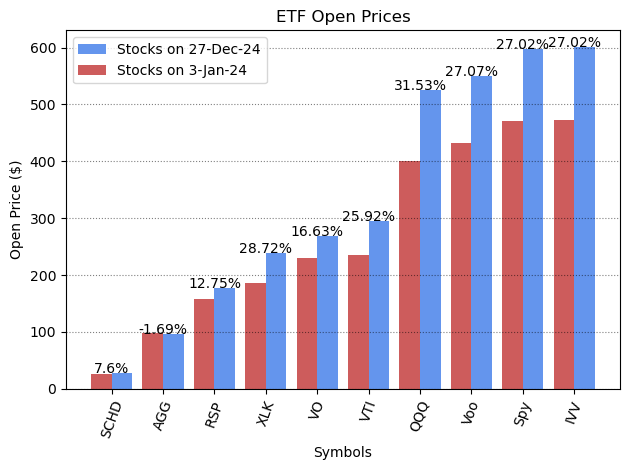

In [76]:
S1 = float(SPY['Open'].iloc[0])
S2 = float(SCHD['Open'].iloc[0])
A1 = float(AGG['Open'].iloc[0])
I1 = float(IVV['Open'].iloc[0])
R1 = float(RSP['Open'].iloc[0])
V1 = float(VO['Open'].iloc[0])
V2 = float(VOO['Open'].iloc[0])
V3 = float(VTI['Open'].iloc[0])
Q1 = float(QQQ['Open'].iloc[0])
X1 = float(XLK['Open'].iloc[0])
SS1 = float(SPY['Open'].iloc[248])
SS2 = float(SCHD['Open'].iloc[248])
AA1 = float(AGG['Open'].iloc[248])
II1 = float(IVV['Open'].iloc[248])
RR1 = float(RSP['Open'].iloc[248])
VV1 = float(VO['Open'].iloc[248])
VV2 = float(VOO['Open'].iloc[248])
VV3 = float(VTI['Open'].iloc[248])
QQ1 = float(QQQ['Open'].iloc[248])
XX1 = float(XLK['Open'].iloc[248])
Names = ['SCHD', 'AGG', 'RSP', 'XLK', 'VO','VTI','QQQ', 'Voo','Spy','IVV']
n = len(Names)
r = np.arange(n)
Stocks = [S2, A1, R1, X1, V1, V3, Q1, V2, S1, I1]
Stocks2 = [SS2, AA1, RR1, XX1, VV1, VV3, QQ1, VV2, SS1, II1]
change = [round(((S2-SS2)/SS2)*100, 2), round(((A1-AA1)/AA1)*100, 2), round(((R1-RR1)/RR1)*100, 2), round(((X1-XX1)/XX1)*100, 2), round(((V1-VV1)/VV1)*100, 2), round(((V3-VV3)/VV3)*100, 2), round(((Q1-QQ1)/QQ1)*100, 2), round(((V2-VV2)/VV2)*100, 2), round(((S1-SS1)/SS1)*100, 2), round(((I1-II1)/II1)*100, 2)]
addpercentage(Names, change, Stocks)

plt.bar(r + 0.20, Stocks, 0.4, label = f'Stocks on {SPY['Date'].iloc[0]}', color = 'cornflowerblue')
plt.bar(r - 0.20, Stocks2, 0.4, label = f'Stocks on {SPY['Date'].iloc[248]}', color = 'indianred')
plt.xticks(r, Names)
plt.xticks(rotation=70)
plt.title(f'ETF Open Prices')
plt.ylabel('Open Price ($)')
plt.xlabel('Symbols')
plt.legend()
plt.grid(axis='y', color = 'black', linestyle=':', alpha=0.5, zorder=0)
plt.tight_layout()
plt.show()

The S&P 500 returns around 10% per year on average. As seen above, many etf's execeeded this rule of thumb. QQQ was had the highest change with 31.53% and AGG had the lowest change with -1.69%. As the graphs suggest, it would be best set to invest in large cap etf's. 

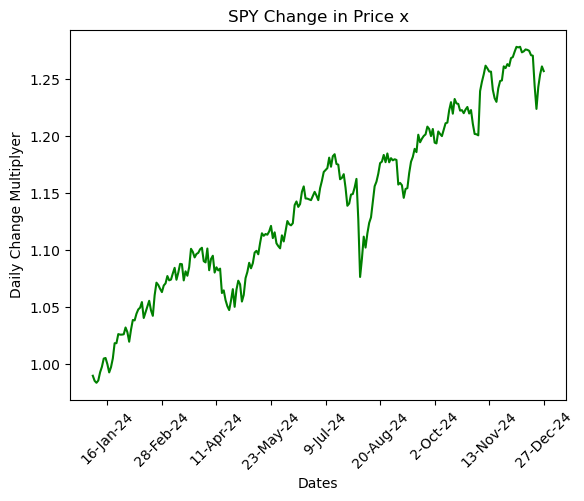

In [79]:
fig, ax = plt.subplots()
ax.set_title('SPY Change in Price x')
ax.plot(SPY['Date'], (SPY['Open']/SPY['Open'].iloc[240]), color='g')

ax.set_xticks([SPY['Date'].iloc[0], SPY['Date'].iloc[30], SPY['Date'].iloc[60], SPY['Date'].iloc[90], SPY['Date'].iloc[120], SPY['Date'].iloc[150], SPY['Date'].iloc[180], SPY['Date'].iloc[210], SPY['Date'].iloc[240]])
plt.xticks(rotation = 45)
ax.set_xlabel('Dates')
plt.gca().invert_xaxis()
ax.set_ylabel('Daily Change Multiplyer')

plt.show()
